In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import tree
from sklearn import metrics

In [95]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#loading
df = pd.read_csv('train_sample_final.csv', sep=';', decimal=',')
sorted_df = df.sort_values(by=['Класс'], ascending=True)
x = sorted_df.copy(deep=True)
y = sorted_df.copy(deep=True)
y = y['Класс']

def sampling(x_full, class_number):
    x_sample = x_full.copy(deep=True)
    for index in range(0,len(x_sample)):
        if (x_sample['Класс'][index] != class_number):
            x_sample.drop(index, inplace=True)
    return x_sample

def choices_for_range(weights_list, begin, mid1, mid2, end):    
    flg = random.choices([1,2,3],weights_list)[0]
    if (flg == 1):
        output = random.randint(begin,mid1-1)
    if (flg == 2):
        output = random.randint(mid1,mid2)
    if (flg == 3):
        output = random.randint(mid2+1,end)
    return output

x_normal = sampling(x, 0)
x_alert = sampling(x, 1)
x_pat = sampling(x, 2)

,Боль_внизу_живота,Тошнота,Количество_рвотных_позывов_за_день,Признаки_ОРВИ,Температура_тела,Сатурация,BLD,KET,LEU,GLU,...,VC,PRO,PH,SG,Артериальное_давление_верхнее,Артериальное_давление_нижнее,Пульс,Глюкоза,Неделя_беременности,Класс
25,0,0,0,0,36.6,99,0,0,0,0,...,0,0,5,1.03,104,62,94,3.3,23,0
27,0,0,0,0,36.6,99,0,0,0,0,...,0,0,5,1.03,106,68,92,3.4,25,0
31,0,0,0,0,36.6,98,0,0,0,0,...,0,0,5,1.03,108,70,96,3.7,28,0
29,0,0,0,0,36.6,98,0,0,0,0,...,0,0,5,1.03,114,64,66,5.1,26,0
20,0,0,0,0,36.6,99,0,0,0,0,...,0,0,5,1.03,107,72,87,5.2,20,0
23,0,0,0,0,36.6,99,0,0,0,0,...,0,0,5,1.03,108,68,94,4.4,22,0
19,0,0,0,0,36.7,99,0,0,0,0,...,0,0,5,1.03,102,57,68,3.9,19,0
32,0,0,0,0,36.6,99,0,0,0,0,...,0,0,5,1.03,109,62,93,4.6,29,0
40,0,0,0,0,36.6,99,0,0,0,0,...,0,0,5,1.03,113,79,90,5.8,37,0
41,0,0,0,0,36.6,98,0,0,0,0,...,0,0,5,1.03,116,74,65,3.6,38,0


In [ ]:
#normal values generation
def NVG(trimester:int, n_samples:int):
    new_data = []
    for iter in range(n_samples):
        sample = []
        #боль внизу живота, тошнота, количество рвотных позвывов за день, признаки орви 
        for zero in range(4):
            sample.append(0)
        #температура тела, сатурация
        sample.append(choices_for_range([1,5,1],362,364,368,369)/10)
        sample.append(random.randint(97,99))
        #BLD
        sample.append(0)
        #KET, LEU
        for ketleu_iter in range(2):
            if (trimester == 1):
                sample.append(random.randint(0,1)) 
            else:
                sample.append(0)
        #GLU
        if (trimester == 0 or trimester == 1):
            sample.append(0)
        else:
            sample.append(random.choices([0,1],[5,1])[0])
        #NIT
        sample.append(0) 
        #URO, BIL, VC
        sample.append(random.randint(0,1))
        for bilvc_iter in range(2):
            sample.append(0)
        #PRO
        if (trimester == 1):
            sample.append(0)
        else:
            sample.append(random.randint(0,1))
        #PH
        sample.append(random.randint(5,7))
        #SG
        sample.append(random.randint(1010,1035)/1000)
        #АД верхнее
        sample.append(random.randint(100, 130))
        #АД нижнее
        sample.append(random.randint(60, 90))
        #Пульс
        if (trimester == 1):
            sample.append(random.randint(60,80))
        if (trimester == 2):
            sample.append(random.randint(70,90))
        if (trimester == 3):
            sample.append(random.randint(70,100))
        #Глюкоза
        sample.append(random.randint(40,55)/10)
        new_data.append(sample)
    new_df = pd.DataFrame(new_data, columns=['Боль_внизу_живота','Тошнота','Количество_рвотных позывов_за_день', 'Признаки_ОРВИ','Температура_тела', 'Сатурация','BLD','KET','LEU','GLU','NIT','URO','BIL','VC','PRO','PH','SG','Артериальное_давление_верхнее','Артериальное_давление_нижнее', 'Пульс', 'Глюкоза'])
    return new_df
norm_sample1 = NVG(1,1000)

In [ ]:
#alert values generation
def AVG(trimester:int, n_samples:int):
    new_data = []
    for iter in range(n_samples):
        sample = []
        #боль внизу живота 
        sample.append(0)
        #тошнота
        if (trimester == 1 or trimester == 2):
            sample.append(random.randint(0,1))
        else:
            sample.append(0)
        #количество рвотных позывов за день
        if (sample[1] == 1):
            if (trimester == 1):
                sample.append(random.randint(1,5))
            if (trimester == 2):
                sample.append(random.randint(1,3))
        else:
            sample.append(0)
        #признаки орви
        sample.append(0)
        #температура тела, сатурация
        sample.append(choices_for_range([1,5,1],359,362,369,372)/10)
        sample.append(choices_for_range([1,2,7],90,95,96,99))
        #BLD
        sample.append(random.randint(0,1))
        #KET
        sample.append(random.randint(0,1))
        #LEU
        if (trimester == 1):
            sample.append(random.choices([0,1,2],[3,3,1])[0])
        else:
            sample.append(random.randint(0,1))
        #GLU
        if (trimester == 0 or trimester == 1):
            sample.append(0)
        else:
            sample.append(random.choices([0,1],[3,1])[0])
        #NIT
        sample.append(random.choices([0,1],[3,1])[0]) 
        #URO, BIL, VC
        sample.append(random.randint(0,2))
        for bilvc_iter in range(2):
            sample.append(random.choices([0,1],[3,1])[0])
        #PRO
        if (trimester == 1):
            sample.append(random.randint(0,1))
        else:
            sample.append(random.randint(0,2))
        #PH
        sample.append(random.choices([5,6,7,8],[5,5,5,1])[0])
        #SG
        sample.append(random.randint(1003,1035)/1000)
        #АД верхнее
        sample.append(choices_for_range([1,5,1],95,100,130,159))
        #АД нижнее
        if (sample[17] < 100):
            sample.append(random.randint(55, 70))
        else:
            sample.append(random.randint(55,100))
        #Пульс
        if (trimester == 1):
            sample.append(choices_for_range([1,5,1],50,60,80,90))
        if (trimester == 2):
            sample.append(choices_for_range([1,5,1],60,70,90,100))
        if (trimester == 3):
            sample.append(choices_for_range([1,5,1],60,70,100,110))
        #Глюкоза
        sample.append(choices_for_range([1,5,1],36,40,55,58)/10)
        if (sample[-1] > 5.5 or sample[13] > 1): #корректировка значения PH по VC и глюкозе крови
            sample[15] = random.randint(4,5)
        new_data.append(sample)
    new_df = pd.DataFrame(new_data, columns=['Боль_внизу_живота','Тошнота','Количество_рвотных позывов_за_день', 'Признаки_ОРВИ','Температура_тела', 'Сатурация','BLD','KET','LEU','GLU','NIT','URO','BIL','VC','PRO','PH','SG','Артериальное_давление_верхнее','Артериальное_давление_нижнее', 'Пульс', 'Глюкоза'])
    return new_df
alert_sample1 = AVG(1,1000)

In [ ]:
#patological values generation
def PVG(trimester:int, n_samples:int):
    new_data = []
    for iter in range(n_samples):
        sample = []
        #боль внизу живота 
        sample.append(random.choices([0,1],[3,1])[0])
        #тошнота
        sample.append(random.randint(0,1))
        #количество рвотных позывов за день
        if (sample[1] == 1):
            if (trimester == 1):
                sample.append(random.randint(6,10))
            if (trimester == 2):
                sample.append(random.randint(4,7))
            if (trimester == 3):
                sample.append(random.randint(0,5))
        else:
            sample.append(0)
        #признаки орви
        sample.append(random.choices([0,1],[3,1])[0])
        #температура тела, сатурация
        if (sample[3] == 1):
            sample.append(choices_for_range([1,5,3],354,362,369,399)/10)
        else:
            sample.append(random.randint(362,369)/10)
        sample.append(choices_for_range([0.5,2,7],85,92,96,99))
        #BLD
        sample.append(random.choices([0,1,2,3],[3,3,1,0.5])[0])
        #KET
        sample.append(random.choices([0,1,2,3],[3,3,1,0.5])[0])
        #LEU
        if (trimester == 1):
            sample.append(random.choices([0,1,2,3],[3,3,1,0.5])[0])
        else:
            sample.append(random.choices([0,1,2],[3,3,1])[0])
        #GLU
        if (trimester == 0 or trimester == 1):
            sample.append(random.choices([0,1,2],[3,1,1])[0])
        else:
            sample.append(random.choices([0,1,2,3],[3,1,1,0.5])[0])
        #NIT
        sample.append(random.choices([0,1,2,3],[5,1,1,0.5])[0]) 
        #URO, BIL, VC
        sample.append(random.randint(0,3))
        for bilvc_iter in range(2):
            sample.append(random.choices([0,1,2,3],[3,1,1,0.5])[0])
        #PRO
        if (trimester == 1):
            sample.append(random.randint(0,2))
        else:
            sample.append(random.randint(0,3))
        #PH
        sample.append(random.choices([5,6,7,8],[3,3,3,1])[0])
        #SG
        sample.append(random.randint(1000,1035)/1000)
        #АД верхнее
        sample.append(choices_for_range([3,1,0.5],100,130,160,170))
        #АД нижнее
        if (sample[17] < 130):
            sample.append(random.randint(55, 90))
        else:
            sample.append(random.randint(90,115))
        #Пульс
        if (trimester == 1):
            sample.append(choices_for_range([0.5,3,1],45,60,80,100))
        if (trimester == 2):
            sample.append(choices_for_range([0.5,3,1],50,70,90,110))
        if (trimester == 3):
            sample.append(choices_for_range([0.5,3,1],50,70,100,120))
        #Глюкоза
        sample.append(choices_for_range([0.5,7,1],30,40,55,65)/10)
        if (sample[-1] > 5.5 or sample[13] > 1): #корректировка значения PH по VC и глюкозе крови
            sample[15] = random.randint(4,5)
        new_data.append(sample)
    new_df = pd.DataFrame(new_data, columns=['Боль_внизу_живота','Тошнота','Количество_рвотных позывов_за_день', 'Признаки_ОРВИ','Температура_тела', 'Сатурация','BLD','KET','LEU','GLU','NIT','URO','BIL','VC','PRO','PH','SG','Артериальное_давление_верхнее','Артериальное_давление_нижнее', 'Пульс', 'Глюкоза'])
    return new_df
pathological_sample1 = PVG(1,1000)

,Боль_внизу_живота,Тошнота,Количество_рвотных позывов_за_день,Признаки_ОРВИ,Температура_тела,Сатурация,BLD,KET,LEU,GLU,...,URO,BIL,VC,PRO,PH,SG,Артериальное_давление_верхнее,Артериальное_давление_нижнее,Пульс,Глюкоза
0,0,1,6,0,36.7,95,0,1,2,0,...,0,0,1,0,8,1.006,118,66,76,4.7
1,0,1,8,0,36.9,99,1,0,2,0,...,0,0,2,1,4,1.016,142,93,75,4.2
2,0,0,0,1,36.9,98,1,1,0,1,...,2,0,0,2,5,1.026,115,58,72,5.2
3,1,0,0,0,36.4,88,1,0,0,2,...,1,2,0,2,5,1.020,118,79,52,4.2
4,0,1,9,0,36.9,99,0,0,1,0,...,1,1,0,2,5,1.015,163,109,96,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,6,0,36.5,97,1,0,1,0,...,3,0,0,2,6,1.011,102,59,62,5.1
996,0,0,0,0,36.8,98,1,2,0,2,...,3,0,0,0,5,1.018,128,88,51,4.1
997,0,1,6,0,36.4,96,0,0,1,0,...,0,0,1,1,5,1.007,115,60,91,4.9
998,0,1,8,1,36.9,96,1,2,0,0,...,1,3,0,0,6,1.022,123,56,72,5.4


In [168]:
#train sample merging
y_norm = pd.DataFrame(np.zeros(1000))
y_alert = pd.DataFrame(np.ones(1000))
y_pathological = pd.DataFrame(np.ones(1000)*2)
y_train = pd.concat([y_norm,y_alert,y_pathological])
y_train.columns = ['Класс']
x_train = pd.concat([norm_sample1, alert_sample1, pathological_sample1], axis=0)
train_sample = pd.concat([x_train,y_train],axis=1)
#перемешивание
train_sample = train_sample.sample(frac=1)
#разделение
y_train = train_sample['Класс']
x_train = train_sample.drop('Класс', axis=1)

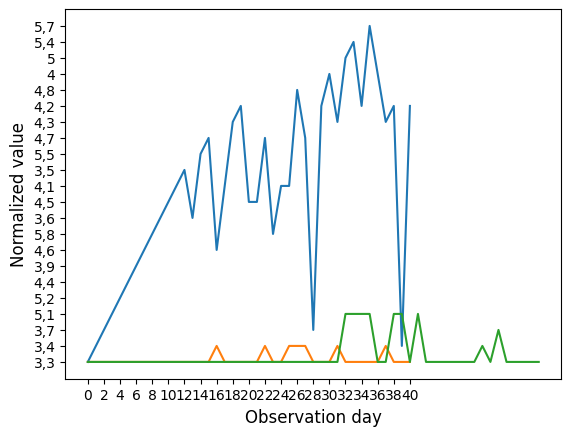

In [15]:
#visualization
xpoints = []
for ipx in range(0,len(x['URO'][0:41])):
    if (ipx%2 == 0):
        xpoints.append(ipx)

plt.figure()
plt.plot(range(0,len(x['Глюкоза'][0:41])), x['Глюкоза'][0:41], label='Нижнее')
plt.plot(range(0,len(x['KET'][0:41])), x['KET'][0:41], label= "Верхнее")
plt.plot(range(0,len(x['GLU'])), x['GLU'], label= 'GLU')
plt.xlabel("Observation day", fontsize=12, labelpad=None, loc=None)
plt.xticks(xpoints)
plt.ylabel("Normalized value", fontsize=12, labelpad=None, loc=None)
#plt.legend()
plt.show()

In [209]:
x_test = NVG(1,100)

In [212]:
#training
model=tree.DecisionTreeClassifier(criterion="entropy")
model.fit(x_train,y_train)
#tree.plot_tree(model)

print(model.predict(x_test)) #.iloc[[0]]))
y_test = np.zeros(100)
counter = 0
for iterator in range(len(x_test)):
    if (model.predict(x_test)[iterator] == y_test[iterator]):
        counter += 1
print(counter)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
99


In [5]:
x_test = pd.read_csv('pregnant1.csv', sep=';')
sorted_x_test = x_test.sort_values(by=['Класс'], ascending=True)
x1 = sorted_x_test.copy(deep=True)
x1 = x1.drop(columns=['Класс'])
x1 = x1.drop(columns=['Неделя_беременности'])
y1 = sorted_x_test.copy(deep=True)
y1 = y1['Класс']
for i in ['Глюкоза','URO','BLD','BIL','KET','LEU','PRO','NIT','SG','VC']:
    for j in range(len(x1[i])):
        if (',' in x1[i][j]):
            x1[i][j] = x1[i][j].replace(',','.')
    x1 = x1.astype({i: float})

print(model.predict(x1.iloc[[0]]))

[1]


In [6]:
y_pred = []
for k in range(len(x)):
    pred = int(model.predict(x.iloc[[k]]))
    y_pred.append(pred)
print(model.predict(x.iloc[[3]]))
metrics.classification_report(y, y_pred)
metrics.confusion_matrix(y, y_pred)

[0]


array([[22,  0,  0],
       [ 0, 15,  0],
       [ 0,  0,  5]])